# <div style="padding: 40px;color: green;margin:10;font-size:90%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://biron-gems.com/wp-content/uploads/2023/03/gemstones-vs-crystals-differences-1170x658.jpg)"><b><span style='color:purple'>Regression with a Mohs Hardness Dataset</span></b> </div>

***

<div style="width:100%;text-align:center"> 
Hardness, a crucial property in materials design, is quantified by resistance to permanent deformation. This dataset aims to predict the Mohs hardness of naturally occurring minerals using a machine learning approach. The dataset is derived from a comprehensive study integrating atomic and electronic features from mineral compositions across various crystal systems.
</div>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import median_absolute_error

train = pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')
sample_sub = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')

# Scatter Plots

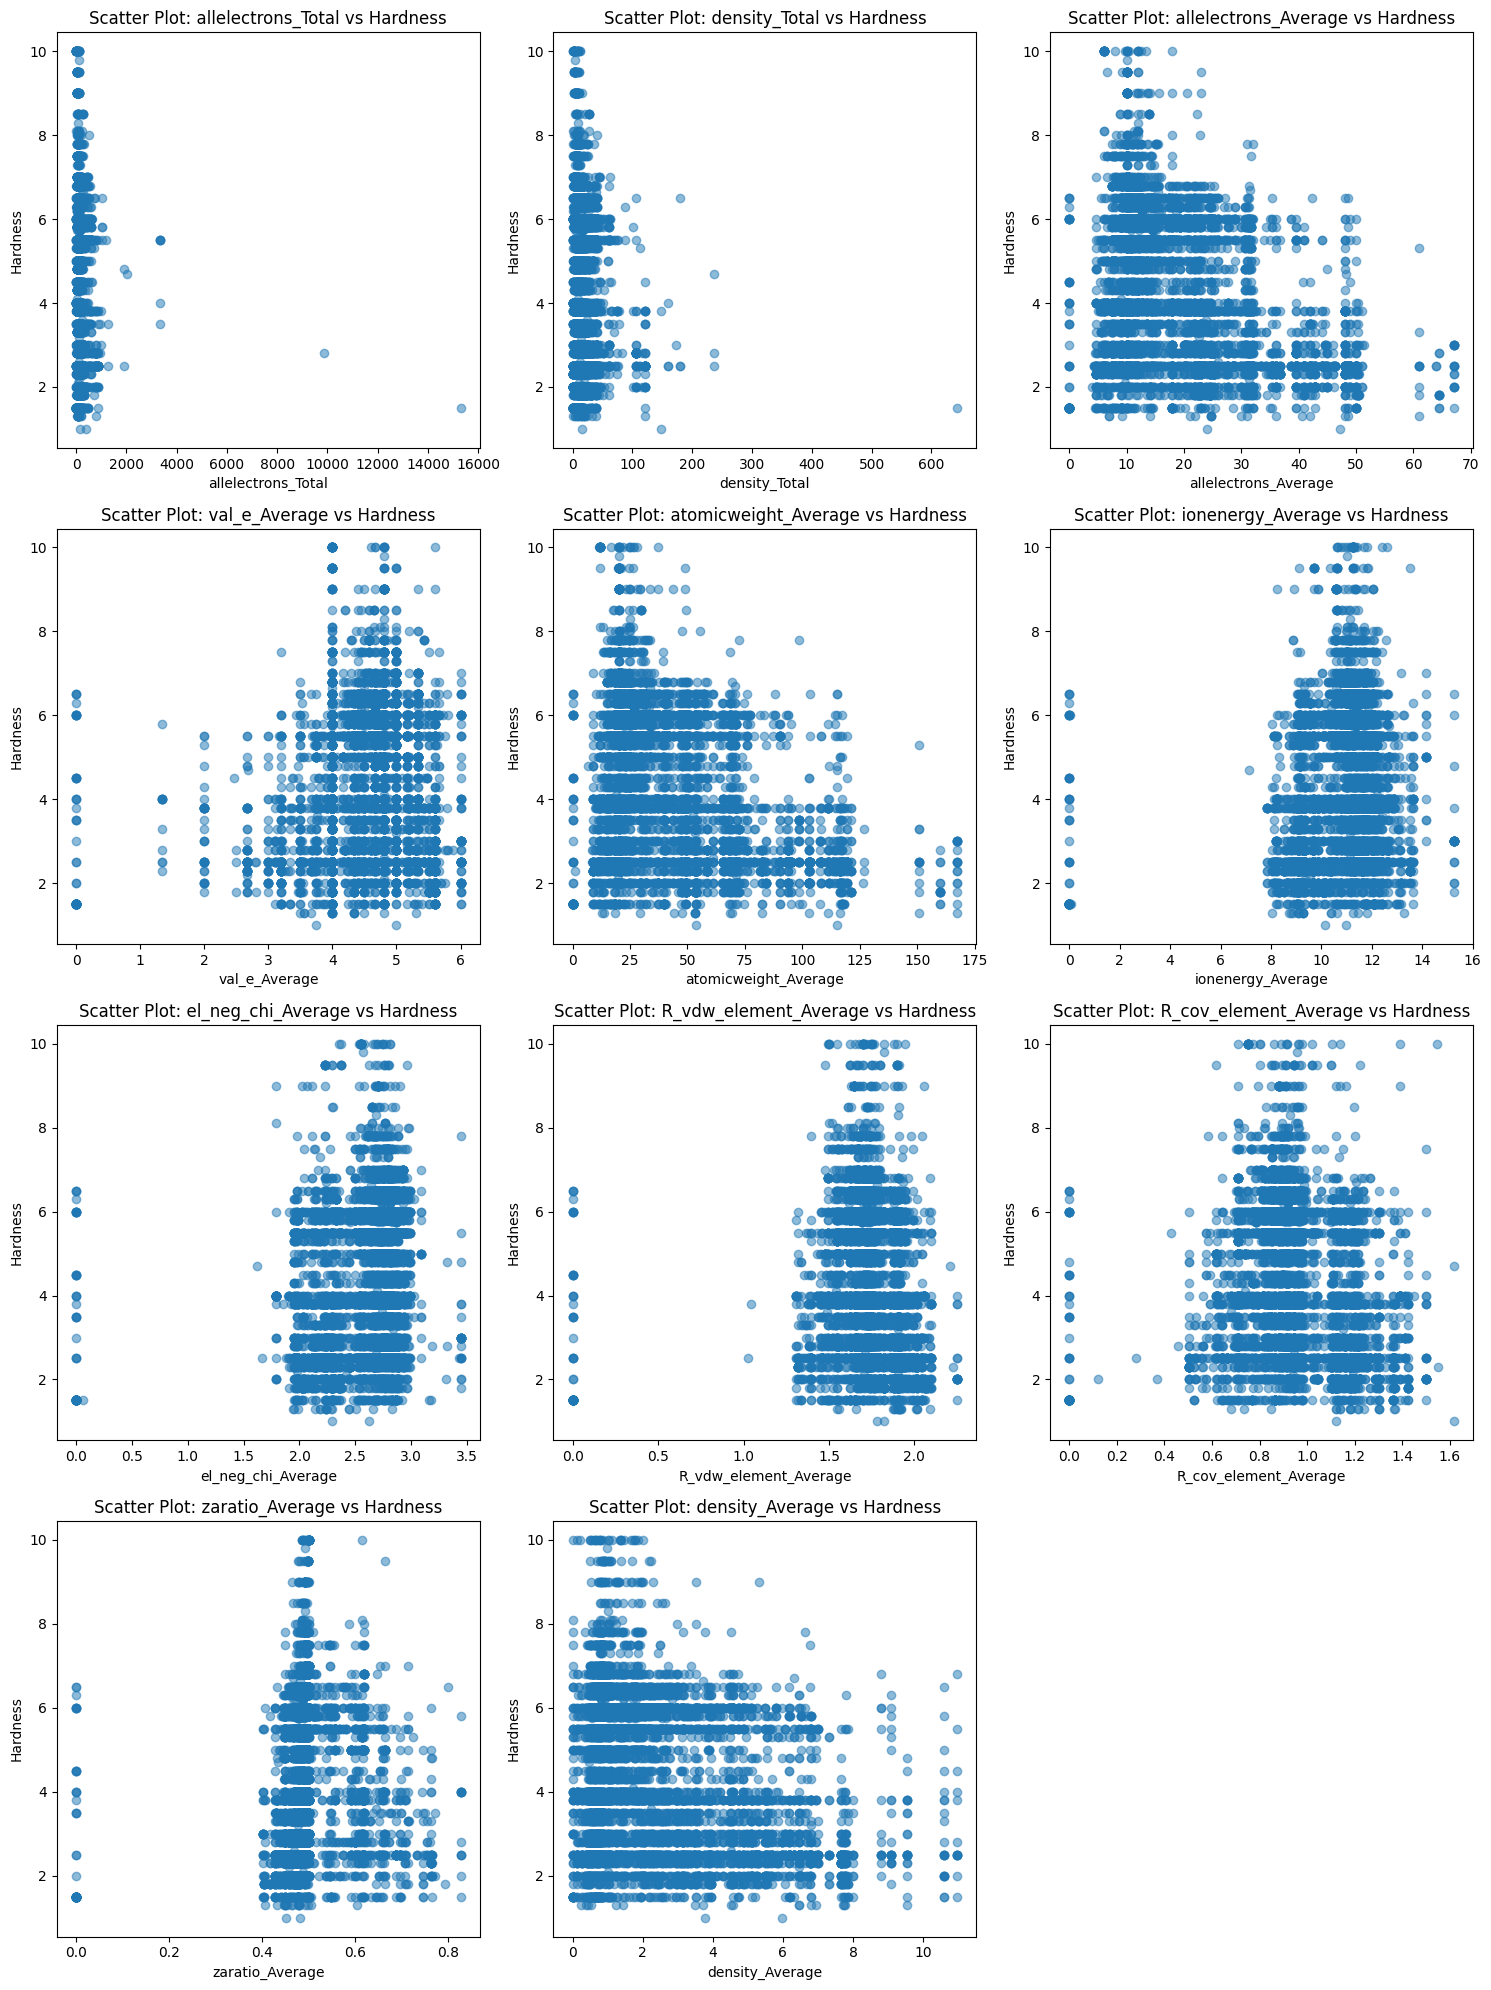

In [2]:
selected_features = ['allelectrons_Total', 'density_Total', 'allelectrons_Average',
                     'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
                     'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
                     'zaratio_Average', 'density_Average', 'Hardness']


num_plots_in_row = 3
num_features = len(selected_features)
num_rows = math.ceil(num_features / num_plots_in_row)

fig, axes = plt.subplots(num_rows, num_plots_in_row, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, (feature, ax) in enumerate(zip(selected_features, axes), 1):
    ax.scatter(train[feature], train['Hardness'], alpha=0.5)
    ax.set_title(f'Scatter Plot: {feature} vs Hardness')
    ax.set_xlabel(feature)
    ax.set_ylabel('Hardness')

for j in range(i, num_features + 1):
    fig.delaxes(axes[j - 1])

plt.tight_layout()
plt.show()

# Target column Distribution

Hardness Statistics:
 count    10407.000000
mean         4.647126
std          1.680525
min          1.000000
25%          3.000000
50%          5.500000
75%          6.000000
max         10.000000
Name: Hardness, dtype: float64


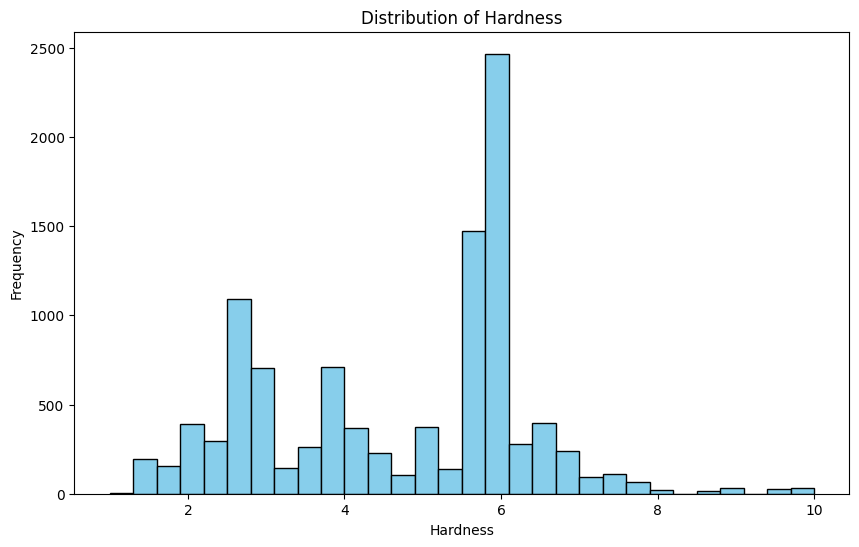

In [3]:
hardness_stats = train['Hardness'].describe()
print("Hardness Statistics:\n", hardness_stats)

plt.figure(figsize=(10, 6))
plt.hist(train['Hardness'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Hardness')
plt.xlabel('Hardness')
plt.ylabel('Frequency')
plt.show()

# Correlation Matrix

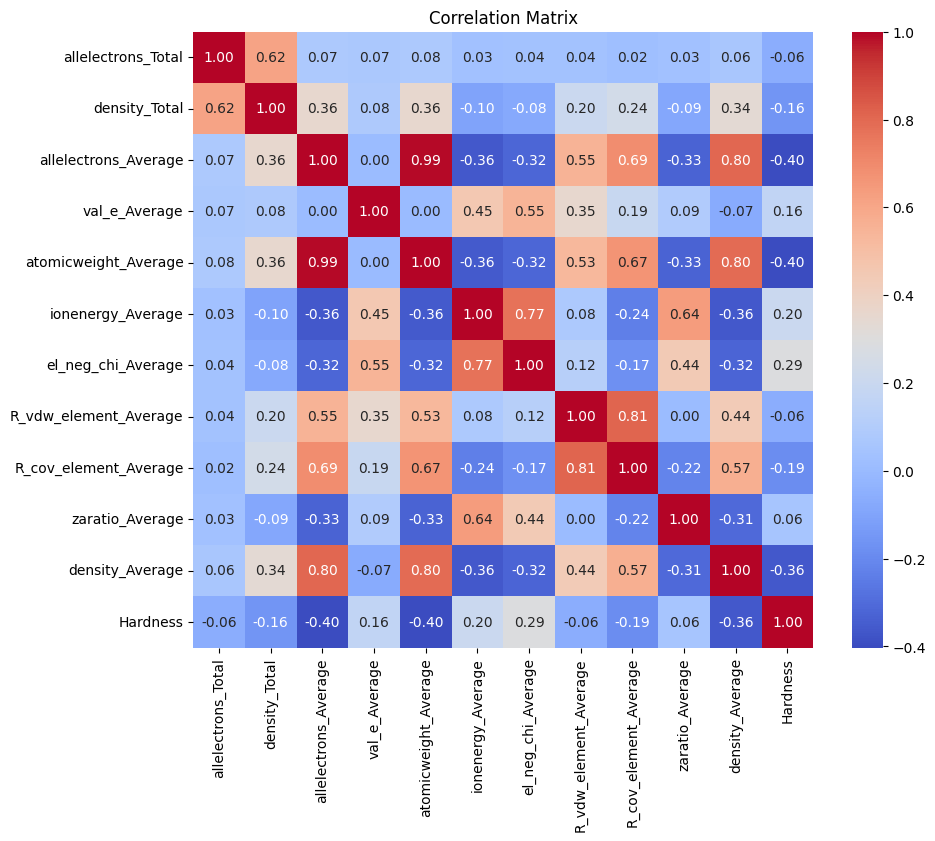

In [4]:
df = train.drop(columns='id', axis=1).copy()

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Feature Distributions

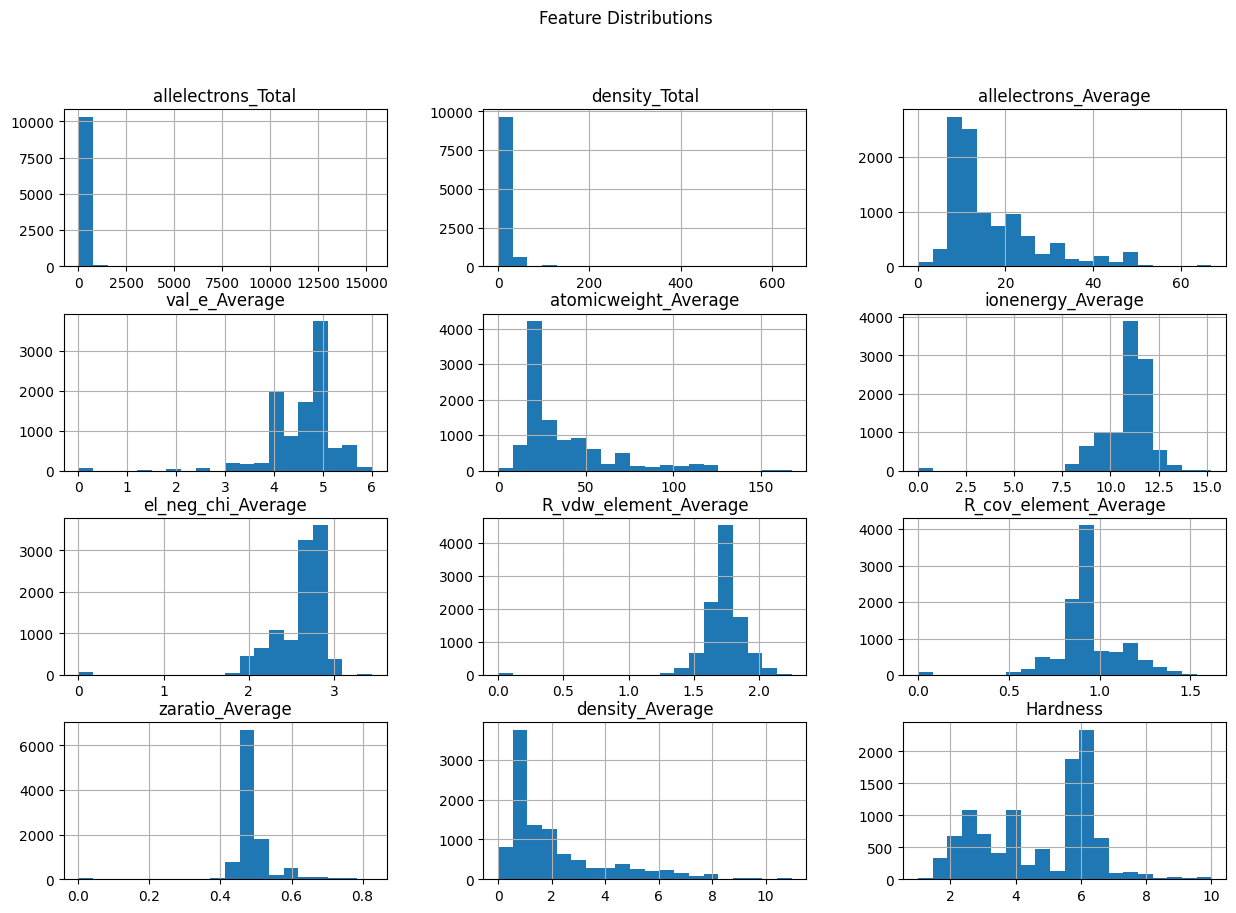

In [5]:
df.hist(bins=20, figsize=(15, 10))
plt.suptitle("Feature Distributions")
plt.show()

# Boxplots of Features

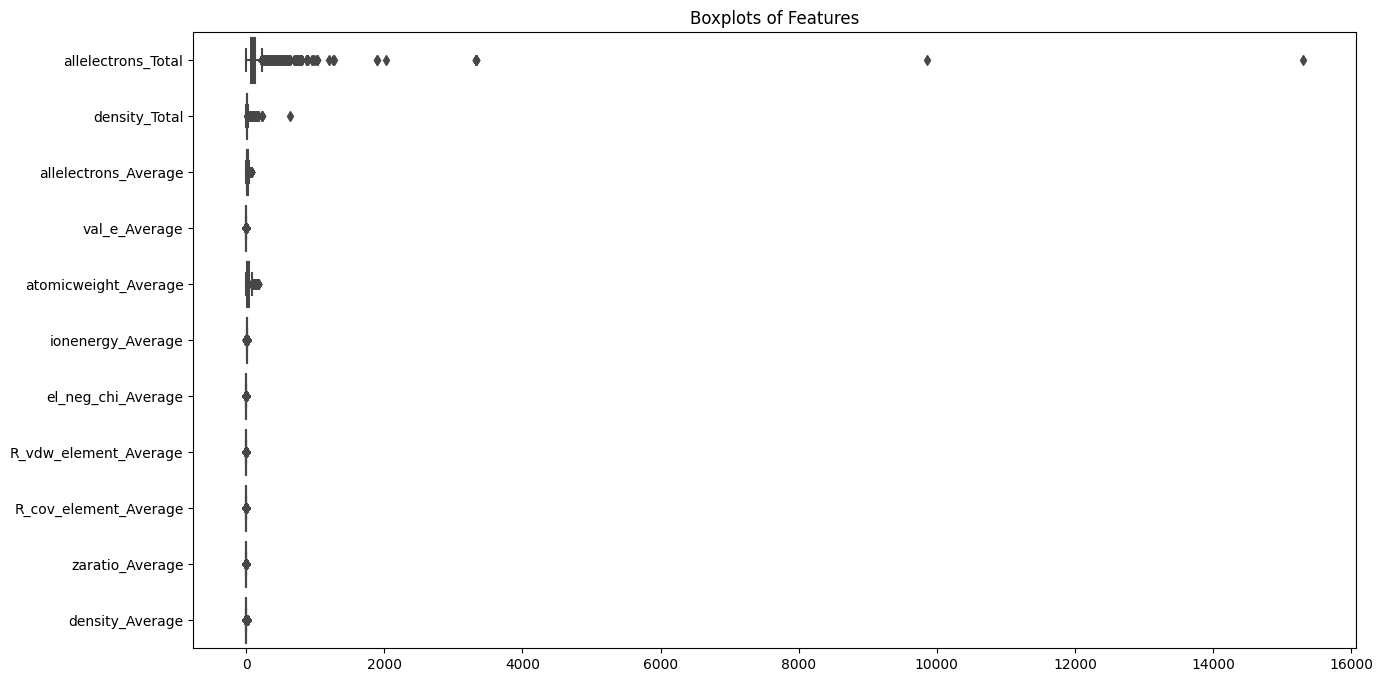

In [6]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df.drop(['Hardness'], axis=1), orient="h")
plt.title("Boxplots of Features")
plt.show()

# Staking Regressor Model

In [7]:
X = train.drop(['Hardness'], axis=1)
y = train['Hardness']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

base_models = [
    ('linear', LinearRegression()),
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42))
]

meta_model = XGBRegressor(random_state=42)
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_regressor.fit(X_train, y_train)
y_pred = stacking_regressor.predict(X_test)

In [8]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 1.6761384963522221
R-squared Score: 0.38115103232417624


# Learning Curve

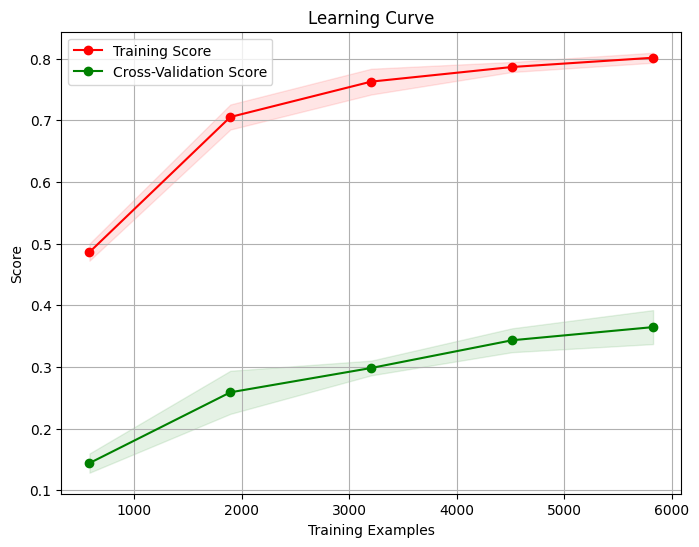

In [9]:
def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
    plt.legend(loc='best')

    plt.show()

# Learning Curve for the StackingRegressor
plot_learning_curve(stacking_regressor, X_train, y_train, cv=5)

In [10]:
#y_pred_test = stacking_regressor.predict(test)
# submission_df = pd.DataFrame({'id': range(10407, 10407 + len(y_pred_test)), 'Hardness': y_pred_test})
# submission_df.to_csv('submission.csv', index=False)